# Load XLM-RoBERTa Ensemble and Predict (Simplified)

This notebook loads the best models saved during cross-validation from a specific training run (`run_id`) and uses them as a weighted ensemble to predict on the test set. 

In [11]:
import sys
import os
import json
import numpy as np
from tqdm.auto import tqdm 
import torch
from collections import defaultdict
import pandas as pd
import textwrap

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.utils import load_cleaned_data, load_config, metrics, plot_confusion_matrix
from src.weighted_ensemble_predict import weighted_ensemble_predict

from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaForSequenceClassification,
    set_seed,
)

import matplotlib.pyplot as plt

## Configuration and Setup

In [12]:
RUN_ID_TO_LOAD = "run_20250410_142742"
CONFIG_PATH = "../cfg/xlm_roberta.json"

config = load_config(CONFIG_PATH)

set_seed(config["seed"])
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device == torch.device("cuda"): torch.cuda.empty_cache()

model_name = config["model"]["base_model"]
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name)
print(f"Tokenizer '{model_name}' loaded.")

model_base_path = config['training']['output_dir']
run_output_dir = os.path.join(model_base_path, RUN_ID_TO_LOAD)
metrics_path = os.path.join(run_output_dir, "fold_metrics.json")
checkpoint_dir = os.path.join(run_output_dir, "fold_checkpoint_paths.json")
n_splits = config["cross_validation"]["n_splits"]

Using device: cuda
Tokenizer 'xlm-roberta-base' loaded.


## Load Fold Metrics and Models

In [13]:
with open(metrics_path, 'r') as f:
    fold_results = json.load(f)

with open(checkpoint_dir, 'r') as f:
    fold_checkpoints = json.load(f)

metric_key = f"eval_{config['training']['metric_for_best_model']}"
fold_f1_scores = [result[metric_key] for result in fold_results]
print(f"Loaded metrics for {len(fold_f1_scores)} folds from {metrics_path}")
print(f"Loaded checkpoints for {len(fold_results)} folds from {checkpoint_dir}")
print(f"Fold F1 scores: {fold_f1_scores}")

fold_models = []
print(f"\nLoading {n_splits} fold models...")
for fold in range(0, n_splits):
    model_path = fold_checkpoints[fold]
    model = XLMRobertaForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()  # Set to evaluation mode
    fold_models.append(model)
    print(f"Loaded model for fold {fold}.")

assert len(fold_models) == n_splits, f"Expected {n_splits} models, but found {len(fold_models)}"
assert len(fold_f1_scores) == n_splits, f"Expected {n_splits} metric scores, but found {len(fold_f1_scores)}"

Loaded metrics for 5 folds from ../models/run_20250410_142742/fold_metrics.json
Loaded checkpoints for 5 folds from ../models/run_20250410_142742/fold_checkpoint_paths.json
Fold F1 scores: [0.8282828282828283, 0.7916666666666666, 0.7777777777777778, 0.7191011235955056, 0.7586206896551724]

Loading 5 fold models...
Loaded model for fold 0.
Loaded model for fold 1.
Loaded model for fold 2.
Loaded model for fold 3.
Loaded model for fold 4.


## Load Test Data and Perform Predictions

In [14]:
test_data = load_cleaned_data(config["data"]["bypublisher_test_data_path"])
# Print all the columns
print("Columns in test data:", test_data.columns.tolist())
X_test = test_data["full_text"]
y_test = test_data["label"]
print(f"Loaded bypublisher data: {len(X_test)} samples.")

y_pred = []
y_pred_proba = []

print("\nStarting ensemble predictions on test data...")
for text in tqdm(X_test, desc="Predicting"): 
    inputs = tokenizer(
        text,
        max_length=config["data"]["max_length"],
        truncation=config["tokenizer"]["truncation"],
        padding=config["tokenizer"]["padding"], 
        add_special_tokens=config["tokenizer"]["add_special_tokens"],
        return_tensors=config["tokenizer"]["return_tensors"]
    ).to(device)
    
    weighted_probs = weighted_ensemble_predict(inputs, fold_models, fold_f1_scores, device)
    
    pred_label = torch.argmax(weighted_probs, dim=1).item()
    confidence = weighted_probs[0][1].item()  # Probability of class 1 (hyperpartisan)
    
    y_pred.append(pred_label)
    y_pred_proba.append(confidence)

y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)
print("Ensemble predictions finished.")

Columns in test data: ['id', 'title', 'body', 'full_text', 'label', 'domain', 'sentiment_score']
Loaded bypublisher data: 4000 samples.

Starting ensemble predictions on test data...


Predicting:   0%|          | 0/4000 [00:00<?, ?it/s]

Ensemble predictions finished.


## Evaluate Ensemble Performance


Ensemble Model Evaluation on bypublisher Test Set:
Accuracy: 0.60
Balanced Accuracy: 0.60
Precision: 0.62
Recall: 0.51
F1: 0.56
AUC: 0.64


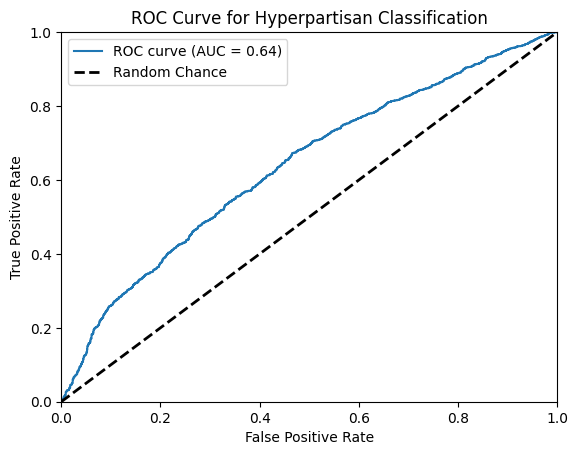

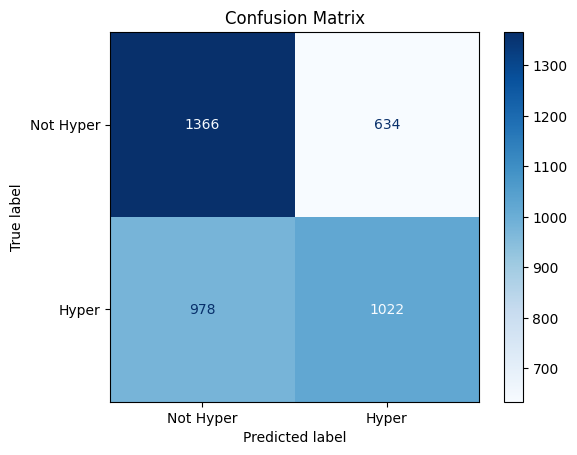

<Figure size 640x480 with 0 Axes>

In [15]:
print("\nEnsemble Model Evaluation on bypublisher Test Set:")

metrics(y_test, y_pred, y_pred_proba)

plot_confusion_matrix(y_test, y_pred)
plt.suptitle(f'Ensemble Confusion Matrix (Run ID: {RUN_ID_TO_LOAD})', y=1.02) # Add title
plt.show()

In [16]:
# Set minimum article count threshold
MIN_ARTICLE_COUNT = 10  # You can adjust this value based on your needs

# Step 1: Create domain stats with label, prediction, and sentiment information
domain_stats = defaultdict(lambda: {
    'count': 0,
    'labels': set(),
    'pred_hyper_count': 0,
    'sentiment_sum': 0.0,  # Initialize sentiment score sum
    'original_indices': []  # Track which rows belong to this domain
})

# Collect domain statistics
for idx, row in test_data.iterrows():
    domain = row['domain']
    label = row['label']
    sentiment = row['sentiment_score'] # Get sentiment score

    domain_stats[domain]['count'] += 1
    domain_stats[domain]['labels'].add(label)
    domain_stats[domain]['original_indices'].append(idx)
    domain_stats[domain]['sentiment_sum'] += sentiment # Accumulate sentiment score

    # Count predicted hyperpartisan articles
    # Ensure idx is within the bounds of y_pred before accessing
    if idx < len(y_pred) and y_pred[idx] == 1:
        domain_stats[domain]['pred_hyper_count'] += 1

# Filter consistent domains (domains with only one type of label)
consistent_domains = []
for domain, stats in domain_stats.items():
    if len(stats['labels']) == 1:  # Only one unique label
        label = list(stats['labels'])[0]  # Get the single label

        # Calculate percentage of articles predicted as hyperpartisan
        percentage_hyper = (stats['pred_hyper_count'] / stats['count']) * 100 if stats['count'] > 0 else 0

        # Calculate average confidence for this domain
        domain_indices = stats['original_indices']
        # Ensure indices are within bounds of y_pred_proba
        valid_indices = [i for i in domain_indices if i < len(y_pred_proba)]
        domain_confidences = [y_pred_proba[i] for i in valid_indices]
        avg_confidence = sum(domain_confidences) / len(domain_confidences) if domain_confidences else 0

        # Calculate average sentiment score for this domain
        avg_sentiment = stats['sentiment_sum'] / stats['count'] if stats['count'] > 0 else 0

        consistent_domains.append({
            'domain': domain,
            'label': label,
            'article_count': stats['count'],
            'pred_hyper_count': stats['pred_hyper_count'],
            'percentage_hyper': percentage_hyper,
            'avg_confidence': avg_confidence,
            'avg_sentiment': avg_sentiment # Add average sentiment
        })

# Create dataframe of consistent publishers
consistent_df = pd.DataFrame(consistent_domains)

# Print summary statistics
num_consistent_domains = len(consistent_df)
num_inconsistent_domains = len(domain_stats) - num_consistent_domains
print(f"\nNumber of consistent domains: {num_consistent_domains}")
print(f"Number of inconsistent domains: {num_inconsistent_domains}")

# Count hyperpartisan and non-hyperpartisan publishers
hyper_pubs = consistent_df[consistent_df['label'] == 1]
non_hyper_pubs = consistent_df[consistent_df['label'] == 0]
print(f"Hyperpartisan publishers: {len(hyper_pubs)}")
print(f"Non-hyperpartisan publishers: {len(non_hyper_pubs)}")

# Filter for publishers with enough articles
filtered_hyper_pubs = hyper_pubs[hyper_pubs['article_count'] >= MIN_ARTICLE_COUNT]
filtered_non_hyper_pubs = non_hyper_pubs[non_hyper_pubs['article_count'] >= MIN_ARTICLE_COUNT]

# Display statistics about filtering
print(f"\nApplying minimum article count threshold of {MIN_ARTICLE_COUNT}:")
print(f"Hyperpartisan publishers before filtering: {len(hyper_pubs)}")
print(f"Hyperpartisan publishers after filtering: {len(filtered_hyper_pubs)}")
print(f"Non-hyperpartisan publishers before filtering: {len(non_hyper_pubs)}")
print(f"Non-hyperpartisan publishers after filtering: {len(filtered_non_hyper_pubs)}")

# Display top publishers of each type, sorted by percentage_hyper
# Added 'avg_sentiment' to the displayed columns
print(f"\nTop 5 hyperpartisan publishers (min {MIN_ARTICLE_COUNT} articles):")
display(filtered_hyper_pubs.sort_values(by='percentage_hyper', ascending=False).head(5)[
    ['domain', 'label', 'article_count', 'pred_hyper_count', 'percentage_hyper', 'avg_confidence', 'avg_sentiment']
])

print(f"\nTop 5 non-hyperpartisan publishers (min {MIN_ARTICLE_COUNT} articles):")
display(filtered_non_hyper_pubs.sort_values(by='percentage_hyper', ascending=False).head(5)[
    ['domain', 'label', 'article_count', 'pred_hyper_count', 'percentage_hyper', 'avg_confidence', 'avg_sentiment']
])

# Find potential mislabeled publishers (where predictions strongly disagree with labels)
potential_mislabeled = consistent_df[
    ((consistent_df['label'] == 1) & (consistent_df['percentage_hyper'] < 30)) |
    ((consistent_df['label'] == 0) & (consistent_df['percentage_hyper'] > 70))
].sort_values(by='percentage_hyper', ascending=False)  # Sort by percentage

# Apply threshold to potential mislabeled publishers
filtered_mislabeled = potential_mislabeled[potential_mislabeled['article_count'] >= MIN_ARTICLE_COUNT]

if len(filtered_mislabeled) > 0:
    print(f"\nPotential mislabeled publishers (min {MIN_ARTICLE_COUNT} articles):")
    # Added 'avg_sentiment' to the displayed columns for mislabeled publishers
    display(filtered_mislabeled[['domain', 'label', 'article_count', 'percentage_hyper', 'avg_sentiment']])

# Save the full results to CSV including the new column
# Added 'avg_sentiment' to the saved columns
consistent_df.to_csv("../results/publisher_analysis.csv", index=False,
                     columns=['domain', 'label', 'article_count', 'pred_hyper_count', 'percentage_hyper', 'avg_confidence', 'avg_sentiment'])

print("\nPublisher analysis complete. Results (including avg_sentiment) saved to ../results/publisher_analysis.csv")


Number of consistent domains: 105
Number of inconsistent domains: 0
Hyperpartisan publishers: 88
Non-hyperpartisan publishers: 17

Applying minimum article count threshold of 10:
Hyperpartisan publishers before filtering: 88
Hyperpartisan publishers after filtering: 67
Non-hyperpartisan publishers before filtering: 17
Non-hyperpartisan publishers after filtering: 17

Top 5 hyperpartisan publishers (min 10 articles):


,domain,label,article_count,pred_hyper_count,percentage_hyper,avg_confidence,avg_sentiment
65,commentarymagazine.com,1,21,20,95.238095,0.812752,-0.475129
68,fixthisnation.com,1,20,19,95.000000,0.776032,0.422605
59,americanconservativeherald.com,1,19,18,94.736842,0.787341,-0.249668
70,bookwormroom.com,1,18,16,88.888889,0.738228,-0.193161
12,patriotpost.us,1,18,16,88.888889,0.748362,-0.222706



Top 5 non-hyperpartisan publishers (min 10 articles):


,domain,label,article_count,pred_hyper_count,percentage_hyper,avg_confidence,avg_sentiment
15,merionwest.com,0,204,163,79.901961,0.672441,0.377064
37,factbox.tv,0,82,41,50.000000,0.468772,-0.594132
9,insidesources.com,0,198,97,48.989899,0.470440,0.517308
50,nj.com,0,13,6,46.153846,0.451021,0.434262
7,outsidethebeltway.com,0,163,68,41.717791,0.411778,0.154505



Potential mislabeled publishers (min 10 articles):


,domain,label,article_count,percentage_hyper,avg_sentiment
15,merionwest.com,0,204,79.901961,0.377064
30,bearingarms.com,1,17,29.411765,-0.562065
35,sovereignman.com,1,14,21.428571,0.012471
52,reviveusa.com,1,10,20.000000,-0.278270
85,conservativetribune.com,1,15,20.000000,0.303233
79,conservativeintel.com,1,15,20.000000,-0.036160
89,usatwentyfour.com,1,11,18.181818,0.069891
42,deneenborelli.com,1,19,15.789474,-0.097937
43,theblaze.com,1,13,15.384615,-0.378946
73,faithfamilyamerica.com,1,10,10.000000,0.286920



Publisher analysis complete. Results (including avg_sentiment) saved to ../results/publisher_analysis.csv


In [17]:
# Find examples of hyperpartisan predictions from non-hyperpartisan sources
def get_misclassification_examples(test_data, y_pred, y_pred_proba, filtered_mislabeled, tokenizer, max_length=512, num_examples=3):
    # Create a combined dataframe with predictions
    prediction_df = test_data.copy()
    prediction_df['pred_label'] = y_pred
    prediction_df['pred_proba'] = y_pred_proba
    
    # Function to get examples from a specific domain
    def get_domain_examples(domain_name, true_label, look_for_pred, num_examples):
        domain_articles = prediction_df[prediction_df['domain'] == domain_name]
        
        # Find articles where model prediction differs from publisher label
        disagreement_articles = domain_articles[domain_articles['pred_label'] == look_for_pred]
        
        # Sort by confidence (highest first)
        sorted_articles = disagreement_articles.sort_values(by='pred_proba', ascending=(not look_for_pred))
        
        # Get top examples
        examples = []
        for _, article in sorted_articles.head(num_examples).iterrows():
            # Tokenize text to show exactly what the model saw
            full_text = article['title'] + ' ' + article['body']
            encoded = tokenizer(
                full_text,
                max_length=max_length,
                truncation=True,
                return_tensors="pt"
            )
            
            # Get the tokens the model actually processed
            input_ids = encoded['input_ids'][0]
            decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
            
            examples.append({
                'domain': domain_name,
                'true_label': true_label,
                'pred_label': look_for_pred,
                'confidence': article['pred_proba'],
                'title': article['title'],
                'processed_text': decoded_text,
                'was_truncated': len(encoded['input_ids'][0]) >= max_length,
                'sentiment_score': article['sentiment_score']
            })
        
        return examples
    
    # Get examples from mislabeled publishers
    examples = []
    
    # Get examples from non-hyperpartisan sources predicted as hyperpartisan
    non_hyper_to_hyper = filtered_mislabeled[filtered_mislabeled['label'] == 0]
    if len(non_hyper_to_hyper) > 0:
        domain = non_hyper_to_hyper.iloc[0]['domain']  # Get the top mislabeled non-hyperpartisan domain
        examples.extend(get_domain_examples(domain, 0, 1, num_examples))
    
    # Get examples from hyperpartisan sources predicted as non-hyperpartisan
    hyper_to_non_hyper = filtered_mislabeled[filtered_mislabeled['label'] == 1]
    if len(hyper_to_non_hyper) > 0:
        # Sort by lowest percentage_hyper to find strongest disagreements
        hyper_to_non_hyper = hyper_to_non_hyper.sort_values(by='percentage_hyper')
        domain = hyper_to_non_hyper.iloc[0]['domain']  # Get the most mislabeled hyperpartisan domain
        examples.extend(get_domain_examples(domain, 1, 0, num_examples))
    
    return examples

# Helper function to format text with wrapping
def format_text(text, width=80):
    # Split into paragraphs
    paragraphs = text.split('\n')
    formatted_paragraphs = []
    
    for p in paragraphs:
        if p.strip():  # Only process non-empty paragraphs
            # Wrap text to specified width
            wrapped = textwrap.fill(p.strip(), width=width)
            formatted_paragraphs.append(wrapped)
    
    # Join paragraphs with double newlines
    return '\n\n'.join(formatted_paragraphs)

# Generate misclassification examples
print("\nGenerating example articles where model disagrees with publisher label...")
misclassification_examples = get_misclassification_examples(
    test_data, 
    y_pred, 
    y_pred_proba, 
    filtered_mislabeled,
    tokenizer,  # Pass the tokenizer
    max_length=config["data"]["max_length"],  # Use the same max_length from config
    num_examples=3
)

# Display examples of non-hyperpartisan sources predicted as hyperpartisan
non_hyper_examples = [ex for ex in misclassification_examples if ex['true_label'] == 0]
if non_hyper_examples:
    print(f"\n\n===== EXAMPLES: NON-HYPERPARTISAN SOURCE PREDICTED AS HYPERPARTISAN =====")
    print(f"Source: {non_hyper_examples[0]['domain']} (labeled as non-hyperpartisan)\n")
    
    for i, example in enumerate(non_hyper_examples):
        print(f"EXAMPLE {i+1} (Confidence: {example['confidence']:.3f})")
        print(f"Sentiment score: {example['sentiment_score']:.3f}")
        print(f"Title: {example['title']}")
        print("\nContent (limited to what the model processed):")
        print(format_text(example['processed_text']))
        if example['was_truncated']:
            print("\n[TEXT WAS TRUNCATED HERE - model only processed up to this point]")
        print("\n" + "-" * 80)

# Display examples of hyperpartisan sources predicted as non-hyperpartisan
hyper_examples = [ex for ex in misclassification_examples if ex['true_label'] == 1]
if hyper_examples:
    print(f"\n\n===== EXAMPLES: HYPERPARTISAN SOURCE PREDICTED AS NON-HYPERPARTISAN =====")
    print(f"Source: {hyper_examples[0]['domain']} (labeled as hyperpartisan)\n")
    
    for i, example in enumerate(hyper_examples):
        print(f"EXAMPLE {i+1} (Confidence: {1-example['confidence']:.3f})") # Confidence for non-hyperpartisan
        print(f"Sentiment score: {example['sentiment_score']:.3f}")
        print(f"Title: {example['title']}")
        print("\nContent (limited to what the model processed):")
        print(format_text(example['processed_text']))
        if example['was_truncated']:
            print("\n[TEXT WAS TRUNCATED HERE - model only processed up to this point]")
        print("\n" + "-" * 80)


Generating example articles where model disagrees with publisher label...


===== EXAMPLES: NON-HYPERPARTISAN SOURCE PREDICTED AS HYPERPARTISAN =====
Source: merionwest.com (labeled as non-hyperpartisan)

EXAMPLE 1 (Confidence: 0.866)
Sentiment score: 0.836
Title: Alabama Radio Host: Trump Tax Politics (Not Quite Policy)

Content (limited to what the model processed):
Alabama Radio Host: Trump Tax Politics (Not Quite Policy) Did Donald Trump sell
the American people on a tax plan that cannot be implemented? Where is the
legislation? &#160;It has been weeks since Treasury Secretary Steve Mnuchin
unveiled the highly anticipated and widely discussed “tax cut package.”
&#160;Did the Trump administration immediately upon announcement of the plan
submit draft legislation to the House Weighs and Means Committee for
consideration? &#160;No, we have seen no legislation on the matter delivered
from the Oval Office. &#160;Did the House Republicans read President Trump’s
outline of suggested tax 

In [18]:
# If you want to analyze a specific publisher more in-depth:
def analyze_specific_publisher(domain_name, prediction_df):
    """Detailed analysis of a specific publisher's articles"""
    # This will raise an error if the domain doesn't exist or prediction_df is malformed
    domain_articles = prediction_df[prediction_df['domain'] == domain_name]

    # This will raise an error if the domain has no articles
    true_label = domain_articles['label'].iloc[0]

    # Count predictions
    hyper_count = (domain_articles['pred_label'] == 1).sum()
    non_hyper_count = (domain_articles['pred_label'] == 0).sum()

    # Calculate percentage
    total = len(domain_articles)
    hyper_pct = hyper_count / total * 100

    # Calculate average sentiment score for this domain's articles
    # This will raise a KeyError if 'sentiment_score' column doesn't exist
    avg_sentiment = domain_articles['sentiment_score'].mean()

    print(f"===== DETAILED ANALYSIS: {domain_name} =====")
    print(f"True label: {'Hyperpartisan' if true_label == 1 else 'Non-hyperpartisan'}")
    print(f"Total articles: {total}")
    print(f"Predicted hyperpartisan: {hyper_count} ({hyper_pct:.1f}%)")
    print(f"Predicted non-hyperpartisan: {non_hyper_count} ({100-hyper_pct:.1f}%)")
    # Print the average sentiment score directly
    print(f"Average Sentiment Score: {avg_sentiment:.4f}")


    # Get most confident examples for each prediction type
    most_confident_hyper = domain_articles[domain_articles['pred_label'] == 1].sort_values(by='pred_proba', ascending=False)
    most_confident_non_hyper = domain_articles[domain_articles['pred_label'] == 0].sort_values(by='pred_proba', ascending=True)

    print("\nMost confident hyperpartisan predictions:")
    for _, article in most_confident_hyper.head(2).iterrows():
        # Display sentiment score for the example article directly
        # This will raise a KeyError if 'sentiment_score' column doesn't exist
        article_sentiment = article['sentiment_score']
        print(f"  Title: {article['title']} (Confidence: {article['pred_proba']:.3f}) (Sentiment: {article_sentiment:.4f})")

    print("\nMost confident non-hyperpartisan predictions:")
    for _, article in most_confident_non_hyper.head(2).iterrows():
        # Display sentiment score for the example article directly
        # This will raise a KeyError if 'sentiment_score' column doesn't exist
        article_sentiment = article['sentiment_score']
        # Confidence for non-hyperpartisan is 1 - pred_proba
        print(f"  Title: {article['title']} (Confidence: {1-article['pred_proba']:.3f}) (Sentiment: {article_sentiment:.4f})")

# Create a combined dataframe with predictions
# This assumes test_data, y_pred, y_pred_proba exist and have correct lengths
# It will raise errors if they don't exist or lengths mismatch
prediction_df = test_data.copy()
prediction_df['pred_label'] = y_pred
prediction_df['pred_proba'] = y_pred_proba

# Example call:
analyze_specific_publisher("merionwest.com", prediction_df)

===== DETAILED ANALYSIS: merionwest.com =====
True label: Non-hyperpartisan
Total articles: 204
Predicted hyperpartisan: 163 (79.9%)
Predicted non-hyperpartisan: 41 (20.1%)
Average Sentiment Score: 0.3771

Most confident hyperpartisan predictions:
  Title: Alabama Radio Host: Trump Tax Politics (Not Quite Policy) (Confidence: 0.866) (Sentiment: 0.8360)
  Title: The Ranging Responses to Trump’s Now Infamous “S–hole” Comment (Confidence: 0.864) (Sentiment: -0.9899)

Most confident non-hyperpartisan predictions:
  Title: ISIS Leader al-Baghdadi Is Reported to Have Been Killed (Confidence: 0.981) (Sentiment: -0.9728)
  Title: Apple and Dell Join Foxconn in Its Bid for Toshiba’s Chip Unit (Confidence: 0.978) (Sentiment: 0.8964)
